In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Delete old data if you want
!rm -rf Masked_data

In [ ]:
# Download dataset
!gdown https://drive.google.com/uc?id=1NkjgaQ8lh2f8oXQ80JW0PfZEAybYWzun&export=download

Downloading...
From: https://drive.google.com/uc?id=1NkjgaQ8lh2f8oXQ80JW0PfZEAybYWzun
To: /content/Masked_data.zip
100% 302M/302M [00:05<00:00, 55.3MB/s]


In [ ]:
# Unzip dataset
!unzip -qq Masked_data.zip
!rm Masked_data.zip

In [ ]:
cd /content/Masked_data


/content/Masked_data


In [ ]:
!python split_train_test_val.py
!pip install keras_cv
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
masked_data/unmasked/5395_61199038.jpg -> masked_data_samp/Train/unmasked/5395_61199038.jpg
masked_data/unmasked/10040_77781721.jpg -> masked_data_samp/Train/unmasked/10040_77781721.jpg
masked_data/unmasked/10074_77907648.jpg -> masked_data_samp/Train/unmasked/10074_77907648.jpg
masked_data/unmasked/8256_70891387.jpg -> masked_data_samp/Train/unmasked/8256_70891387.jpg
masked_data/unmasked/7630_68857308.jpg -> masked_data_samp/Train/unmasked/7630_68857308.jpg
masked_data/unmasked/3701_49299188.jpg -> masked_data_samp/Train/unmasked/3701_49299188.jpg
masked_data/unmasked/4176_54259285.jpg -> masked_data_samp/Train/unmasked/4176_54259285.jpg
masked_data/unmasked/11029_81822544.jpg -> masked_data_samp/Train/unmasked/11029_81822544.jpg
masked_data/unmasked/1044_19413403.jpg -> masked_data_samp/Train/unmasked/1044_19413403.jpg
masked_data/unmasked/14249_image_2010.jpg -> masked_data_samp/Train/unmasked/14249_image_2010.jpg
masked_data


# Define functions



In [ ]:
import matplotlib.pyplot as plt
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))  # Set the figure size
    for n in range(min(25, len(image_batch))):  # Display 25 images or total images if less than 25
        ax = plt.subplot(5, 5, n+1)  # Create a subplot for each image
        plt.imshow(image_batch[n])  # Display the nth image
        # Convert the label to string for display
        plt.title(str(label_batch[n].numpy()))
        plt.axis('off')  # Turn off the axis
    plt.show()

In [ ]:
def extract_labels(dataset):
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels.numpy())
    return all_labels

def compute_weights(y_train):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    return dict(enumerate(class_weights))

def apply_class_weight_conditionally(dataset, condition):
    if condition:
        y_train = extract_labels(dataset)
        return compute_weights(y_train)
    else:
        return None

#Load data, proprocessing, augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom,
                                     RandomContrast, RandomBrightness,
                                      Rescaling)
import keras_cv
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# Function to load dataset with dynamic image size
def load_dataset(img_height, img_width, batch_size, use_augmentation):
    print(f"Loading datasets with image size: {img_height}x{img_width} and batch size: {batch_size}")
    train_dataset = image_dataset_from_directory('/content/Masked_data/masked_data_samp/Train', image_size=(img_height, img_width), batch_size=batch_size)
    val_dataset = image_dataset_from_directory('/content/Masked_data/masked_data_samp/Val', image_size=(img_height, img_width), batch_size=batch_size)
    test_dataset = image_dataset_from_directory('/content/Masked_data/masked_data_samp/Test', image_size=(img_height, img_width), batch_size=batch_size)

    # ==============Augmentation and normalization
    use_augmentation = use_augmentation  # Set this to False for debugging, True for training
    # Retrieve a single batch of images from the train dataset
    image_batch, label_batch = next(iter(train_dataset))

    # Normalize pixel values to [0,1] as they were rescaled before
    original_images = image_batch.numpy().astype("uint8")

    # Visualize the original batch
    print("Original images:")
    show_batch(original_images, label_batch)

    # Define the data augmentation layer (if needed)
    if use_augmentation:
        print("Start augmentation.......")
        data_augmentation = Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(0.1),
            preprocessing.RandomZoom(0.1),
            preprocessing.RandomCrop(img_height, img_width),
            # Photometric transformations
            preprocessing.RandomContrast(factor=0.2),  # Adjust contrast by up to 20%
            # preprocessing.RandomBrightness(factor=0.2),  # Adjust brightness by up to 20%
            keras_cv.layers.RandomSaturation(factor=(0.0, 1.0)),  # Adjust saturation randomly within the range
            preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images
            # Add more transformations as needed
        ])

        # Apply the data augmentation to the batch
        augmented_images = data_augmentation(image_batch)
        augmented_images = augmented_images.numpy().astype("uint8")

        # Visualize the augmented batch
        print("Augmented images:")
        show_batch(augmented_images, label_batch)
    else:
        print("Data augmentation is turned off.")

    # Preprocess the data
    normalization_layer = preprocessing.Rescaling(1./255)
    if use_augmentation:
        train_dataset = train_dataset.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
    else:
        train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
    test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
    return train_dataset, val_dataset, test_dataset


#Model

In [ ]:
def build_model(img_height, img_width, use_augmentation):
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(MaxPooling2D(2, 2))

    # Hidden layers
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # Flatten the results to feed into a DNN
    model.add(Flatten())

    # 512 neuron hidden layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer with units equal to the number of classes
    model.add(Dense(7, activation='softmax'))  # Change the number 7 to the number of classes you have

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#*Train* with progressive image resizing

In [ ]:
import os

# Define the desired path
desired_path = '/content/gdrive/MyDrive/Mask_Recognition/output/'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(desired_path), exist_ok=True)

Loading datasets with image size: 80x80 and batch size: 32
Found 10716 files belonging to 2 classes.
Found 2295 files belonging to 2 classes.
Found 2299 files belonging to 2 classes.
Original images:


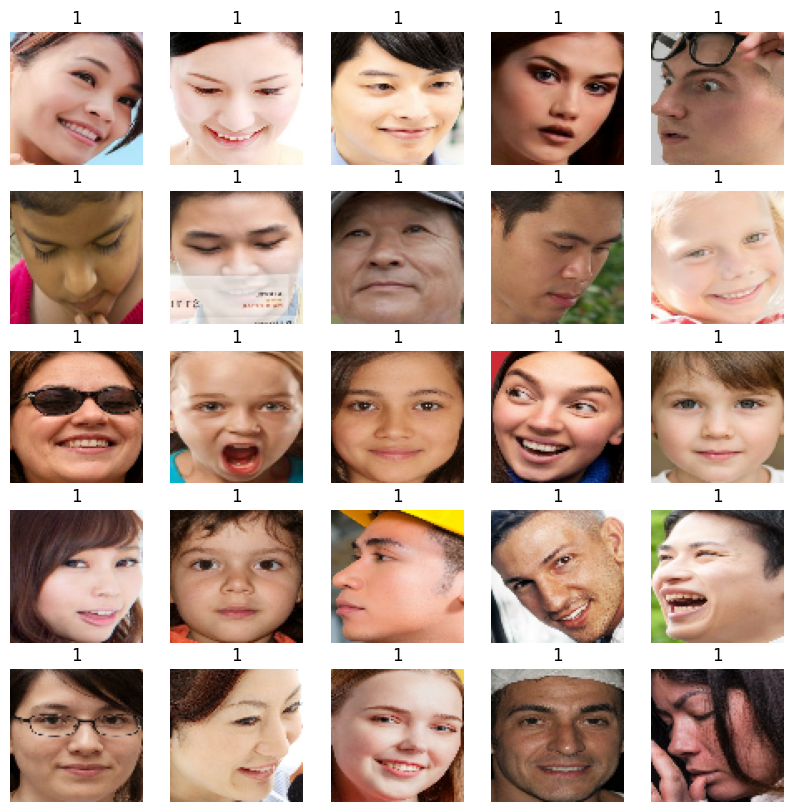

Start augmentation.......
Augmented images:


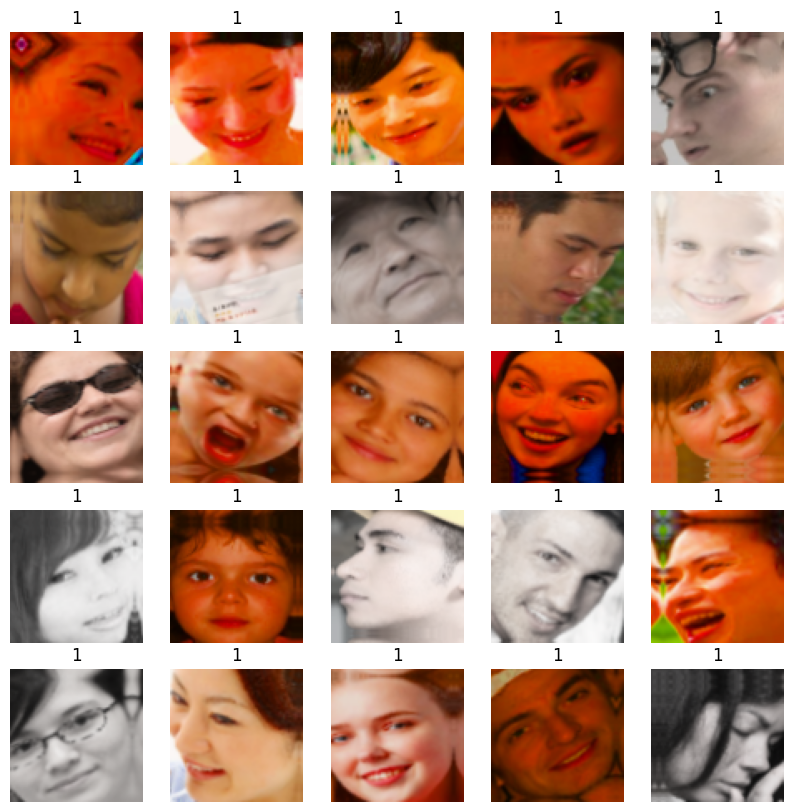

Class weight is turned off.
Epoch 1/30
335/335 [==============================] - 48s 125ms/step - loss: 0.1308 - accuracy: 0.9700 - val_loss: 0.0511 - val_accuracy: 0.9891
Epoch 2/30
335/335 [==============================] - 41s 121ms/step - loss: 0.0878 - accuracy: 0.9801 - val_loss: 0.0527 - val_accuracy: 0.9895
Epoch 3/30
335/335 [==============================] - 41s 121ms/step - loss: 0.0776 - accuracy: 0.9809 - val_loss: 0.0609 - val_accuracy: 0.9813
Epoch 4/30
335/335 [==============================] - 39s 117ms/step - loss: 0.0752 - accuracy: 0.9819 - val_loss: 0.0618 - val_accuracy: 0.9834
Epoch 5/30
335/335 [==============================] - 40s 118ms/step - loss: 0.0707 - accuracy: 0.9828 - val_loss: 0.0834 - val_accuracy: 0.9834
Epoch 6/30
335/335 [==============================] - 41s 120ms/step - loss: 0.0639 - accuracy: 0.9835 - val_loss: 0.0485 - val_accuracy: 0.9878
Epoch 7/30
335/335 [==============================] - 40s 118ms/step - loss: 0.0813 - accuracy: 0.9810

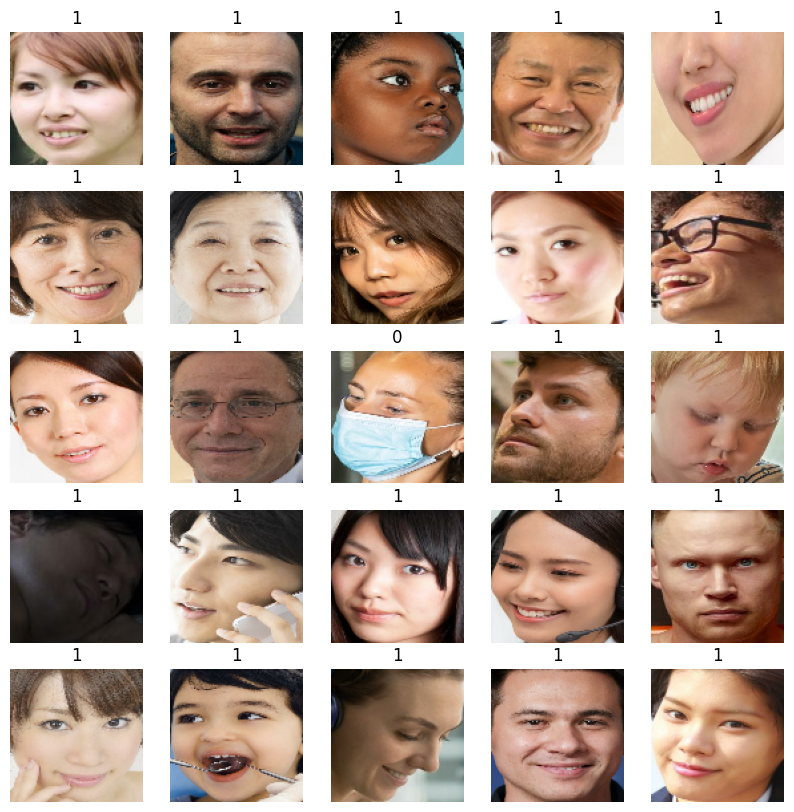

Start augmentation.......
Augmented images:


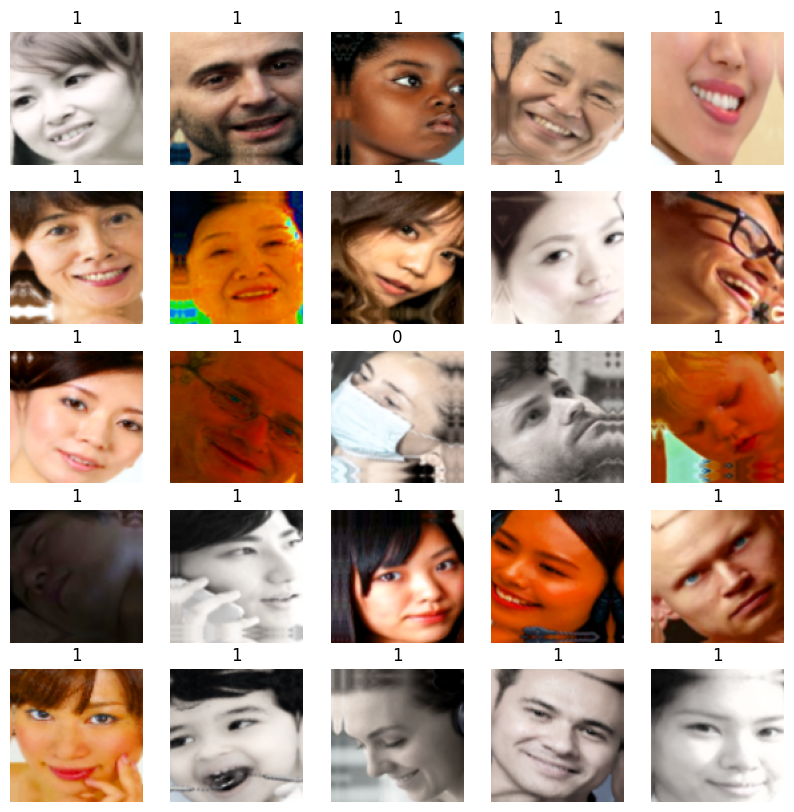

Class weight is turned off.
Epoch 1/30
335/335 [==============================] - 63s 181ms/step - loss: 0.1484 - accuracy: 0.9685 - val_loss: 0.0571 - val_accuracy: 0.9826
Epoch 2/30
335/335 [==============================] - 58s 174ms/step - loss: 0.1009 - accuracy: 0.9751 - val_loss: 0.0759 - val_accuracy: 0.9752
Epoch 3/30
335/335 [==============================] - 58s 172ms/step - loss: 0.0883 - accuracy: 0.9790 - val_loss: 0.0382 - val_accuracy: 0.9913
Epoch 4/30
335/335 [==============================] - 61s 181ms/step - loss: 0.0784 - accuracy: 0.9812 - val_loss: 0.0796 - val_accuracy: 0.9717
Epoch 5/30
335/335 [==============================] - 57s 171ms/step - loss: 0.0779 - accuracy: 0.9810 - val_loss: 0.0439 - val_accuracy: 0.9856
Epoch 6/30
335/335 [==============================] - 58s 174ms/step - loss: 0.0731 - accuracy: 0.9831 - val_loss: 0.0414 - val_accuracy: 0.9913
Epoch 7/30
335/335 [==============================] - 57s 171ms/step - loss: 0.0712 - accuracy: 0.9817

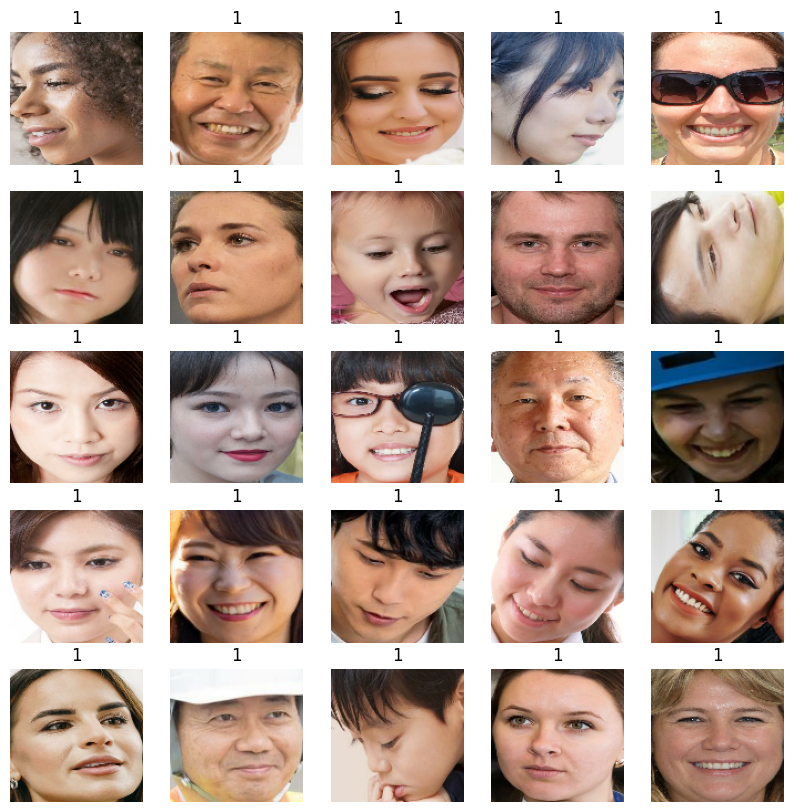

Start augmentation.......
Augmented images:


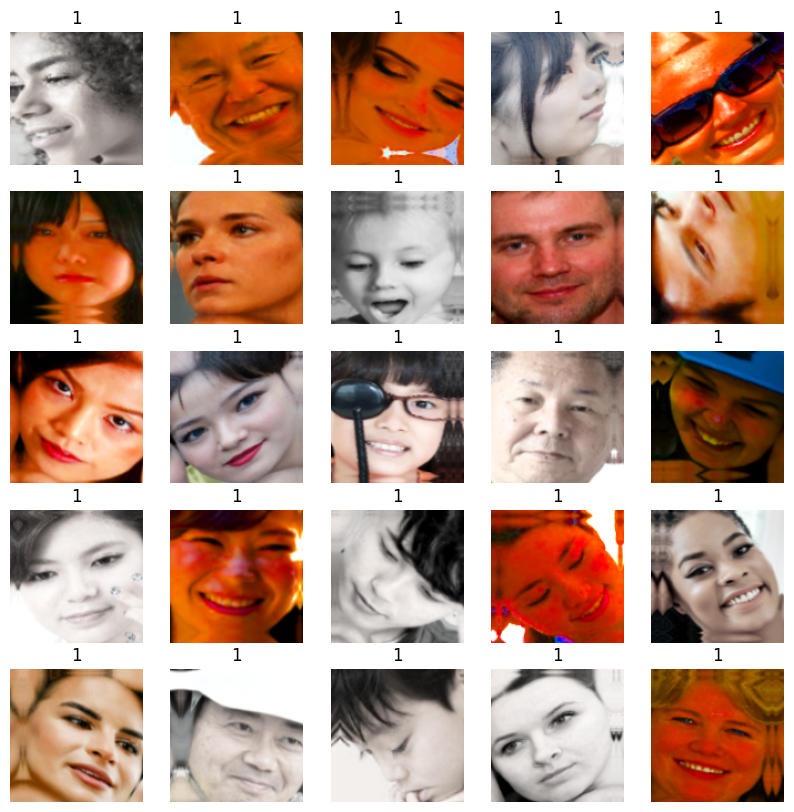

Class weight is turned off.
Epoch 1/30
335/335 [==============================] - 85s 244ms/step - loss: 0.1376 - accuracy: 0.9691 - val_loss: 0.0896 - val_accuracy: 0.9734
Epoch 2/30
335/335 [==============================] - 78s 233ms/step - loss: 0.0908 - accuracy: 0.9789 - val_loss: 0.0304 - val_accuracy: 0.9917
Epoch 3/30
335/335 [==============================] - 80s 238ms/step - loss: 0.0779 - accuracy: 0.9817 - val_loss: 0.0385 - val_accuracy: 0.9874
Epoch 4/30
335/335 [==============================] - 81s 240ms/step - loss: 0.0727 - accuracy: 0.9823 - val_loss: 0.0374 - val_accuracy: 0.9887
Epoch 5/30
335/335 [==============================] - 79s 234ms/step - loss: 0.0654 - accuracy: 0.9838 - val_loss: 0.0384 - val_accuracy: 0.9913
Epoch 6/30
335/335 [==============================] - 79s 235ms/step - loss: 0.0720 - accuracy: 0.9821 - val_loss: 0.0365 - val_accuracy: 0.9900
Epoch 7/30
335/335 [==============================] - 78s 231ms/step - loss: 0.0672 - accuracy: 0.9820

In [ ]:
batch_size = 32
condition_to_apply_weights = False  # Set this based on your specific needs
use_augmentation = True

# Progressive resizing schedule (example: double size after 30 epochs)
sizes = [(80, 80), (100,100), (120, 120)]  # Define your sizes here
epochs_per_size = [30, 30, 30]  # Define how many epochs to train for each size
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath="/content/gdrive/MyDrive/Mask_Recognition/output/model_best.hdf5",
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

for i, (new_height, new_width) in enumerate(sizes):
    # Update dataset with new image size
    train_dataset, val_dataset, test_dataset = load_dataset(new_height, new_width, batch_size, use_augmentation)

    class_weight_dict = apply_class_weight_conditionally(train_dataset, condition_to_apply_weights)

    # Print class weights if they're applied
    if class_weight_dict:
        print("Class weights are:", class_weight_dict)
    else:
        print("Class weight is turned off.")


    # Rebuild and recompile the model with new input shape
    model = build_model(new_height, new_width, use_augmentation)

    # Continue training
    model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_per_size[i],
              class_weight=class_weight_dict,
              callbacks = early_stopping)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')